全文参考: https://blog.csdn.net/u014096903/article/details/79980036

### 1.导入包

In [4]:
import warnings 
import itertools 
import pandas as pd 
import numpy as np 
import statsmodels.api as sm 
import matplotlib.pyplot as plt 
plt.style.use('fivethirtyeight') # matplotlib 图形显示风格

### 2.加载并处理数据

In [3]:
# 加载名为“来自美国夏威夷Mauna Loa天文台的连续空气样本的大气二氧化碳”的数据集，该数据集从1958年3月至2001年12月期间收集了二氧化碳样本。
data = sm.datasets.co2.load_pandas()
# 数据默认是周采样
y = data.data 
# 按月重采样
y = y['co2'].resample('MS').mean() 
# 用前面的值进行填充 NAN
y = y.fillna(y.bfill())
print(y)

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
                 ...    
2001-08-01    369.425000
2001-09-01    367.880000
2001-10-01    368.050000
2001-11-01    369.375000
2001-12-01    371.020000
Freq: MS, Name: co2, Length: 526, dtype: float64


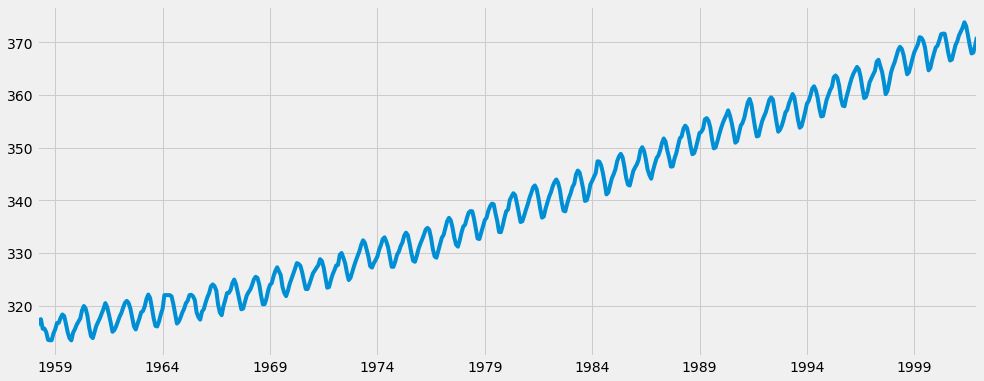

In [6]:
# 探索数据 
# 时间序列具有明显的季节性格局，总体呈上升趋势。
y.plot(figsize=(15,6))
plt.show()

### 3.ARIMA时间序列模型
时间序列预测中最常用的方法之一就是被称为ARIMA模型，它代表了<strong>A</strong> utoreg <strong>R</strong> essive综合<strong>M</strong> oving <strong>A</strong>版本 。 ARIMA是可以适应时间序列数据的模型，以便更好地了解或预测系列中的未来点。

有三个不同的整数（ p ， d ， q ）用于参数化ARIMA模型。 因此，ARIMA模型用符号ARIMA(p, d, q) 。 这三个参数共计数据集中的季节性，趋势和噪音：

- p是模型的自回归部分。 它允许我们将过去价值观的影响纳入我们的模型。 直观地说，这将是类似的，表示如果过去3天已经变暖，明天可能会变暖。
- d是模型的集成部分。 这包括模型中包含差异量（即从当前值减去的过去时间点的数量）以适用于时间序列的术语。 直观地说，这将类似于说如果过去三天的温度差异非常小，明天可能会有相同的温度。
- q是模型的移动平均部分。 这允许我们将模型的误差设置为过去以前时间点观察到的误差值的线性组合。

在处理季节性影响时，我们利用季节性 ARIMA，表示为ARIMA(p,d,q)(P,D,Q)s 。 这里， (p, d, q)是上述非季节性参数，而(P, D, Q)遵循相同的定义，但适用于时间序列的季节分量。 术语s是时间序列的周期（季度为4 ，年度为12 ，等等）。

由于所涉及的多个调整参数，季节性ARIMA方法可能会令人望而生畏。 在下一节中，我们将介绍如何自动化识别季节性ARIMA时间序列模型的最优参数集的过程。



### 4.ARIMA时间序列模型的参数选择
当考虑使用季节性ARIMA模型拟合时间序列数据时，我们的第一个目标是找到优化感兴趣度量的ARIMA(p,d,q)(P,D,Q)s的值。 实现这一目标有许多指导方针和最佳实践，但ARIMA模型的正确参数化可能是一个需要领域专长和时间的艰苦的手工过程。 其他统计编程语言（如R提供了自动化的方法来解决这个问题 ，但尚未被移植到Python中。 在本节中，我们将通过编写Python代码来编程选择ARIMA(p,d,q)(P,D,Q)s时间序列模型的最优参数值来解决此问题。

我们将使用“网格搜索”来迭代地探索参数的不同组合。 对于参数的每个组合，我们使用statsmodels模块的SARIMAX()函数拟合一个新的季节性ARIMA模型，并评估其整体质量。 一旦我们探索了参数的整个范围，我们的最佳参数集将是我们感兴趣的标准产生最佳性能的参数。 我们开始生成我们希望评估的各种参数组合：

In [7]:
# Define the p,d and q parameters to take any value between 0 and 2 
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets 
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, d and q triplets 
seasonal_pdq = [(x[0],x[1],x[2],12) for x in list(itertools.product(p,d,q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1],seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[2],seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[3],seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[4],seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 1, 0) x (0, 1, 0, 12)
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (1, 0, 0) x (1, 0, 0, 12)


我们现在可以使用上面定义的参数三元组来自动化不同组合对ARIMA模型进行培训和评估的过程。 在统计和机器学习中，这个过程被称为模型选择的网格搜索（或超参数优化）。

在评估和比较配备不同参数的统计模型时，可以根据数据的适合性或准确预测未来数据点的能力，对每个参数进行排序。 我们将使用AIC （Akaike信息标准）值，该值通过使用statsmodels安装的ARIMA型号方便地返回。 AIC衡量模型如何适应数据，同时考虑到模型的整体复杂性。 在使用大量功能的情况下，适合数据的模型将被赋予比使用较少特征以获得相同的适合度的模型更大的AIC得分。 因此，我们有兴趣找到产生最低AIC值的模型。

下面的代码块通过参数的组合来迭代，并使用SARIMAX函数来适应相应的季节性ARIMA模型。 这里， order参数指定(p, d, q)参数，而seasonal_order参数指定季节性ARIMA模型的(P, D, Q, S)季节分量。 在安装每个SARIMAX()模型后，代码打印出其各自的AIC得分。

In [13]:
warnings.filterwarnings('ignore') # specify to ignore warning messages 

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, 
                                            order=param, 
                                            seasonal_order=param_seasonal, 
                                            enforce_stationarity=False, 
                                            enforce_invertibility=False)
            results = mod.fit() 
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
        except Exception as e :
            print(e)
            continue 

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7612.583429881011
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6787.343624044862
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1854.8282341412219
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1596.711172763659
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1058.9388921320035
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1056.287828580544
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1361.6578978076
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1044.7647913181027
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6881.048755403754
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6072.662327691604
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1379.1941066985476
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1241.417471688153
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1101.8050544624562
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:780.4315985589685
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1119.5957893644259
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:807.0912988039684
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1675.8086923024293
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1240.2211199194057
ARIM

SARIMAX(1, 1, 1)x(1, 1, 1, 12)产生最低的AIC值为277.78。 因此，我们认为这是我们考虑过的所有模型中的最佳选择。

### 5.安装ARIMA时间序列模型

使用网格搜索，我们已经确定了为我们的时间序列数据生成最佳拟合模型的参数集。 我们可以更深入地分析这个特定的模型。

我们首先将最佳参数值插入到新的SARIMAX模型中：

In [9]:
mod = sm.tsa.statespace.SARIMAX(y, order=(1,1,1), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit() 
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3182      0.092      3.442      0.001       0.137       0.499
ma.L1         -0.6254      0.077     -8.162      0.000      -0.776      -0.475
ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
ma.S.L12      -0.8769      0.026    -33.811      0.000      -0.928      -0.826
sigma2         0.0972      0.004     22.632      0.000       0.089       0.106


由SARIMAX的输出产生的SARIMAX返回大量的信息，但是我们将注意力集中在系数表上。 coef列显示每个特征的重量（即重要性）以及每个特征如何影响时间序列。 P>|z| 列通知我们每个特征重量的意义。 这里，每个重量的p值都低于或接近0.05 ，所以在我们的模型中保留所有权重是合理的。

在适合季节性ARIMA模型（以及任何其他模型）的情况下，运行模型诊断是非常重要的，以确保没有违反模型的假设。 plot_diagnostics对象允许我们快速生成模型诊断并调查任何异常行为。

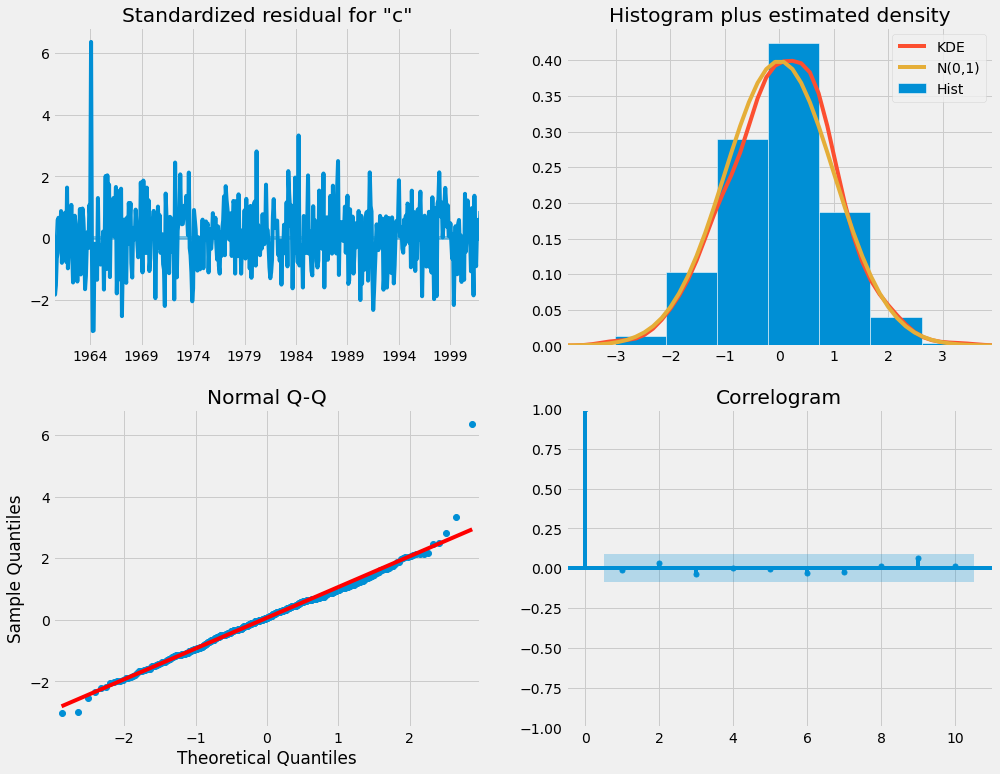

In [14]:
results.plot_diagnostics(figsize=(15,12))
plt.show()

我们的主要关切是确保我们的模型的残差是不相关的，并且平均分布为零。 如果季节性ARIMA模型不能满足这些特性，这是一个很好的迹象，可以进一步改善。

在这种情况下，我们的模型诊断表明，模型残差正常分布如下：

- 在右上图中，我们看到红色KDE线与N(0,1)行（其中N(0,1) ）是正态分布的标准符号，平均值0 ，标准偏差为1 ） 。 这是残留物正常分布的良好指示。

- 左下角的qq图显示，残差（蓝点）的有序分布遵循采用N(0, 1)的标准正态分布采样的线性趋势。 同样，这是残留物正常分布的强烈指示。

- 随着时间的推移（左上图）的残差不会显示任何明显的季节性，似乎是白噪声。 这通过右下角的自相关（即相关图）来证实，这表明时间序列残差与其本身的滞后版本具有低相关性。

这些观察结果使我们得出结论，我们的模型产生了令人满意的合适性，可以帮助我们了解我们的时间序列数据和预测未来价值。

虽然我们有一个令人满意的结果，我们的季节性ARIMA模型的一些参数可以改变，以改善我们的模型拟合。 例如，我们的网格搜索只考虑了一组受限制的参数组合，所以如果我们拓宽网格搜索，我们可能会找到更好的模型。



### 6.验证预测
我们已经获得了我们时间序列的模型，现在可以用来产生预测。 我们首先将预测值与时间序列的实际值进行比较，这将有助于我们了解我们的预测的准确性。 get_prediction()和conf_int()属性允许我们获得时间序列预测的值和相关的置信区间。

In [15]:
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'),dynamic=False )
pred_ci = pred.conf_int()

上述规定需要从1998年1月开始进行预测。

dynamic=False参数确保我们产生一步前进的预测，这意味着每个点的预测都将使用到此为止的完整历史生成。

我们可以绘制二氧化碳时间序列的实际值和预测值，以评估我们做得如何。 注意我们如何在时间序列的末尾放大日期索引。

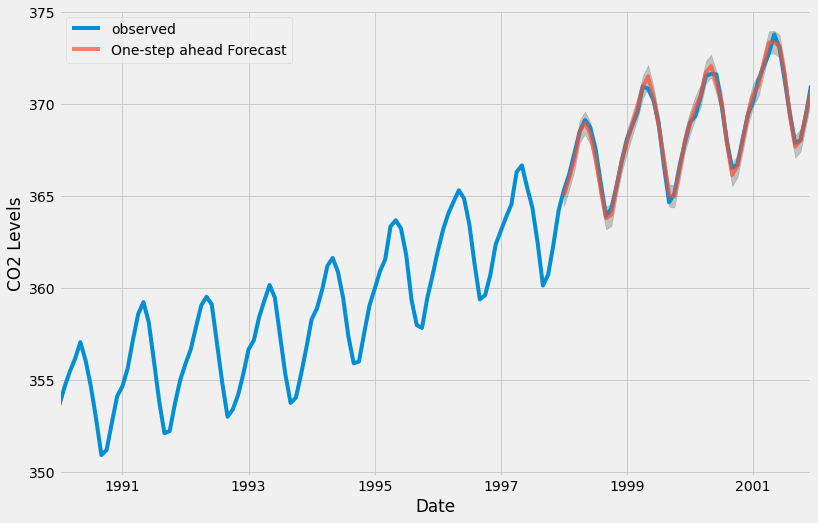

In [20]:
ax = y['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast',alpha=.7, figsize=(12,8))
ax.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1],color='k',alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend() 
plt.show()

总体而言，我们的预测与真实价值保持一致，呈现总体增长趋势。

量化我们的预测的准确性也是有用的。 我们将使用MSE（均方误差），它总结了我们的预测的平均误差。 对于每个预测值，我们计算其到真实值的距离并对结果求平方。 结果需要平方，以便当我们计算总体平均值时，正/负差异不会相互抵消。

In [21]:
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error 
mse = ((y_forecasted - y_truth)**2).mean() 
print('The Mean Squared Error of our forecasts is {}'.format(round(mse,2)))

The Mean Squared Error of our forecasts is 0.07


我们前进一步预测的MSE值为0.07 ，这是接近0的非常低的值。0的MSE是估计器将以完美的精度预测参数的观测值，这将是一个理想的场景但通常不可能。

然而，使用动态预测可以获得更好地表达我们的真实预测能力。 在这种情况下，我们只使用时间序列中的信息到某一点，之后，使用先前预测时间点的值生成预测。

在下面的代码块中，我们指定从1998年1月起开始计算动态预测和置信区间。

In [30]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1998-01-01'),dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()


绘制时间序列的观测值和预测值，我们看到即使使用动态预测，总体预测也是准确的。 所有预测值（红线）与地面真相（蓝线）相当吻合，并且在我们预测的置信区间内。

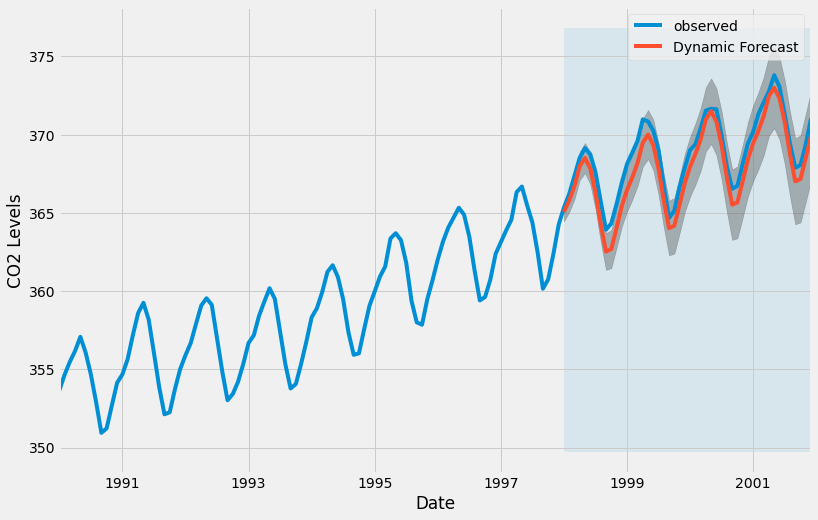

In [38]:
ax = y['1990':].plot(label='observed', figsize=(12,8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)
ax.fill_between(pred_dynamic_ci.index, 
               pred_dynamic_ci.iloc[:,0],
               pred_dynamic_ci.iloc[:,1], color='k',alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'),y.index[-1],alpha=.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
# plt.title('二氧化碳浓度动态预测')
plt.legend()
plt.show()

In [40]:
# 计算MSE量化我们预测的预测性能
# Extract the predicted and true values of our time-series 
y_forecasted = pred_dynamic.predicted_mean 
y_truth = y['1998-01-01':]

# Compute the mean square error 
mse = ((y_forecasted - y_truth)**2).mean() 
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.01


从动态预测获得的预测值产生1.01的MSE。 这比前进一步略高，这是预期的，因为我们依赖于时间序列中较少的历史数据。

前进一步和动态预测都证实了这个时间序列模型是有效的。 然而，关于时间序列预测的大部分兴趣是能够及时预测未来价值观。

### 7.生成和可视化预测
在本教程的最后一步，我们将介绍如何利用季节性ARIMA时间序列模型来预测未来的价值。 我们的时间序列对象的get_forecast()属性可以计算预先指定数量的步骤的预测值。

In [41]:
# Get forecast 500 steps ahead in future 
pred_uc = results.get_forecast(steps=500)
# Get confidence intervals of forecasts 
pred_ci = pred_uc.conf_int()

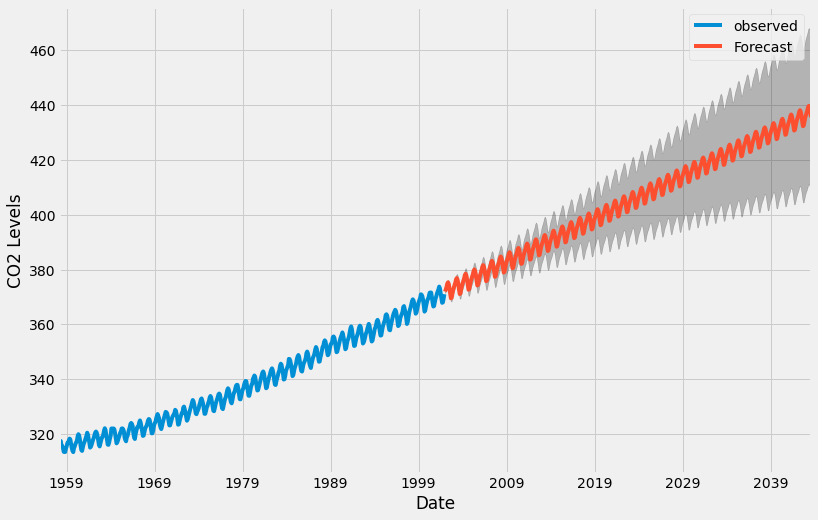

In [42]:
# 绘制图形
ax = y.plot(label='observed', figsize=(12,8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:,0],pred_ci.iloc[:,1], color='k',alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show() 